## Importing Libraries

In [21]:
!pip install tensorflow_text
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


     |████████████████████████████████| 4.9 MB 16.2 MB/s 
     |████████████████████████████████| 462 kB 54.0 MB/s 


## Getting Data for repo (Note: downloading 20k rct data to find the best preforming model)



In [2]:
##Getting Train data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
##Getting validation data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
## Getting test data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt

--2022-05-09 14:12:17--  https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28908792 (28M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]  27.57M   145MB/s    in 0.2s    

2022-05-09 14:12:17 (145 MB/s) - ‘train.txt’ saved [28908792/28908792]

--2022-05-09 14:12:17--  https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

In [3]:
## moving them to new folder
! mkdir rct20k
! mv dev.txt rct20k/
! mv train.txt rct20k/
! mv test.txt rct20k/

mkdir: cannot create directory ‘rct20k’: File exists


## EDA and visualization of Data

In [4]:
##Getting lines from the files
def get_data(dataset_type,rct_type):
  parent_folder='/content/'
  with open(str(parent_folder+rct_type+"/"+dataset_type),'r') as f:
    list_lines= f.readlines()
    return list_lines

In [5]:
train_lines_20k=get_data("train.txt","rct20k")
test_lines_20k=get_data("test.txt","rct20k")
val_lines_20k=get_data("dev.txt","rct20k")

In [6]:
len(train_lines_20k),len(test_lines_20k),len(val_lines_20k)

(210040, 35135, 35212)

In [7]:
## function to create dataframe from lines
def convert_to_df(lines):
  abstract_size=0
  dict_list=[]
  abstract=[]
  list_abstract=[]
  for line in lines:
    if(line.startswith("###")):
      if(len(abstract)!=0):
        list_abstract.append(abstract)
      abstract=[]
    else:
      abstract.append(line)
  list_abstract.append(abstract)
  for new_abstract in list_abstract:
    count=0
    for line in new_abstract:
      count+=1
      splitted=line.split('\t')
      if(splitted[0]=='\n'):
        continue
      category=splitted[0]
      text=splitted[1]
      dict_list.append({'target':category,'text':text,'location':float(count/len(new_abstract))})
  list_df=pd.DataFrame(dict_list)
  return list_df


In [8]:
##convert lines to dataframe
train_df=convert_to_df(train_lines_20k)
val_df=convert_to_df(val_lines_20k)
test_df=convert_to_df(test_lines_20k)

In [9]:
train_df.head(15)

,target,text,location
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0.076923
1,METHODS,A total of @ patients with primary knee OA wer...,0.153846
2,METHODS,Outcome measures included pain reduction and i...,0.230769
3,METHODS,Pain was assessed using the visual analog pain...,0.307692
4,METHODS,Secondary outcome measures included the Wester...,0.384615
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",0.461538
6,RESULTS,There was a clinically relevant reduction in t...,0.538462
7,RESULTS,The mean difference between treatment arms ( @...,0.615385
8,RESULTS,"Further , there was a clinically relevant redu...",0.692308
9,RESULTS,These differences remained significant at @ we...,0.769231


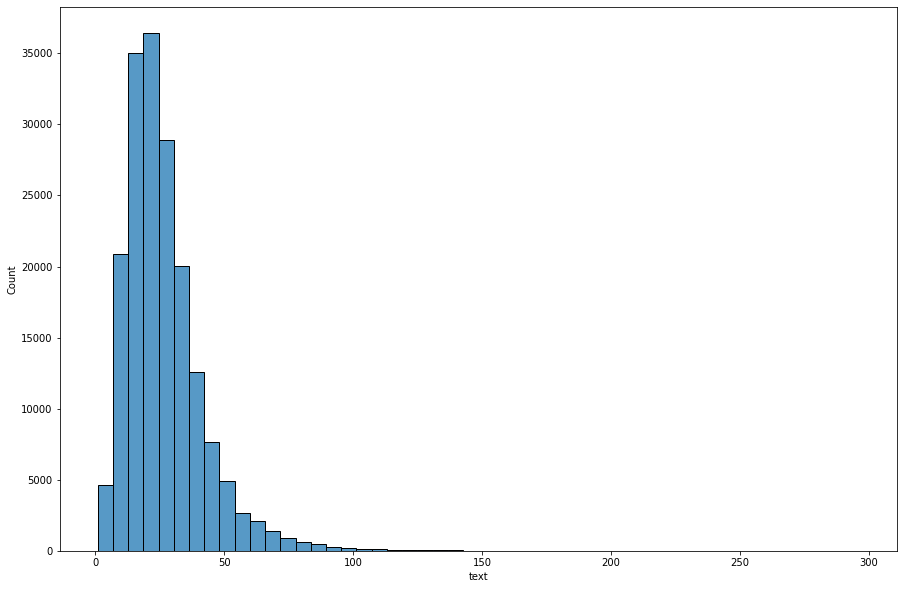

In [10]:
#length line in a abstract
plt.figure(figsize=(15,10))
sns.histplot(x=train_df['text'].apply(lambda x: len(x.split(' '))),bins=50)

In [11]:
## Shortening all sentence to max length of 50
def shorten(text):
  lists=text.split(" ")
  size=np.minimum(50,len(lists))
  t = " ".join(lists[:size])
  return t
train_df['text']=train_df['text'].apply(shorten)
test_df['text']=test_df['text'].apply(shorten)
val_df['text']=val_df['text'].apply(shorten)

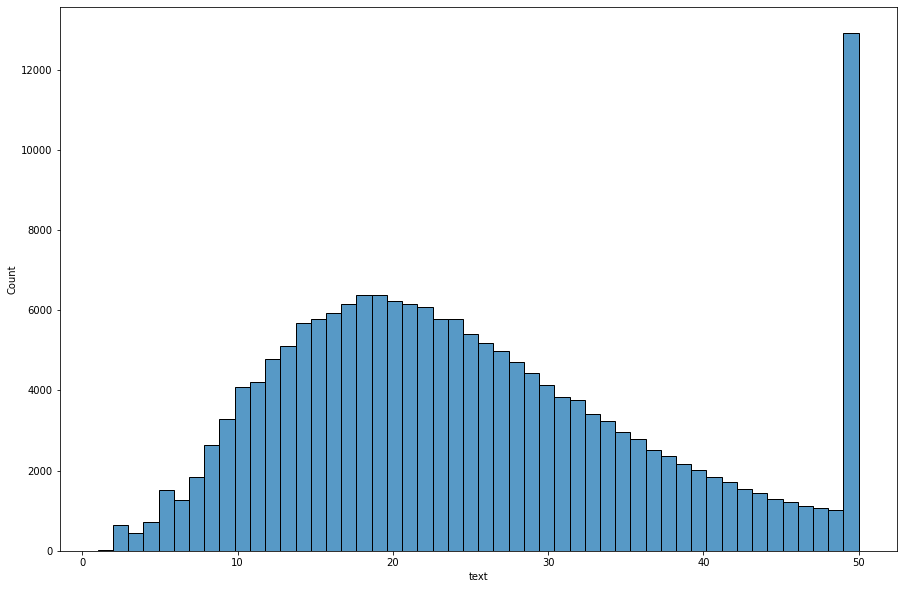

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(x=train_df['text'].apply(lambda x: len(x.split(' '))),bins=50)

In [13]:
## one hot Encoding The  classes
num_classes=train_df['target'].nunique()
class_names=list(train_df['target'].unique())
train_df['target']=train_df['target'].apply(lambda x: class_names.index(x))
def onehotencoding(data,classes):
  return tf.one_hot(data,classes)
train_labels=onehotencoding(train_df['target'],num_classes)

In [14]:
test_df['target']=test_df['target'].apply(lambda x: class_names.index(x))
val_df['target']=val_df['target'].apply(lambda x: class_names.index(x))
test_labels=onehotencoding(test_df['target'],num_classes)
val_labels=onehotencoding(val_df['target'],num_classes)

## Turning DataFrame to tf.data.dataset for faster computing 

In [15]:
from tensorflow.data import Dataset

In [16]:
train_dataset=Dataset.from_tensor_slices((train_df['text'].to_numpy(),train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=Dataset.from_tensor_slices((test_df['text'].to_numpy(),test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=Dataset.from_tensor_slices((val_df['text'].to_numpy(),val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## Modelling using BERT

In [23]:
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow_text as text

In [24]:
#BERT PREPROCESSOR
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")


In [40]:
# loading BERT Embedding
encoder = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2")

In [41]:
## Modelling
Input = layers.Input(shape=(),dtype=tf.string)
x = preprocessor(Input)
x = encoder(x,training=False)
pooled_output = x["pooled_output"] 
x = layers.Dense(128,activation='relu')(pooled_output)
Output = layers.Dense(num_classes,activation='softmax')(x)

In [42]:
Model2 = tf.keras.Model(Input,Output)
Model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=Adam(),metrics=['accuracy'])
Model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_5[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [43]:
batch_train_10precent=int(len(train_dataset)*0.1)
batch_val_10precent=int(len(val_dataset)*0.1)

In [44]:
earlystop=EarlyStopping(monitor='val_accuracy',patience=2,mode='max',verbose=0,restore_best_weights=True)

In [45]:
history= Model2.fit(train_dataset,
                    steps_per_epoch=batch_train_10precent,
                    epochs=1000,
                    validation_data=val_dataset,
                    validation_steps=batch_val_10precent,
                    callbacks=[earlystop])

Epoch 1/1000
562/562 [==============================] - 216s 372ms/step - loss: 0.5561 - accuracy: 0.8056 - val_loss: 0.4463 - val_accuracy: 0.8454
Epoch 2/1000
562/562 [==============================] - 211s 376ms/step - loss: 0.4598 - accuracy: 0.8355 - val_loss: 0.4404 - val_accuracy: 0.8275
Epoch 3/1000
562/562 [==============================] - 211s 376ms/step - loss: 0.4414 - accuracy: 0.8397 - val_loss: 0.4216 - val_accuracy: 0.8484
Epoch 4/1000
562/562 [==============================] - 211s 376ms/step - loss: 0.4348 - accuracy: 0.8453 - val_loss: 0.4030 - val_accuracy: 0.8577
Epoch 5/1000
562/562 [==============================] - 211s 376ms/step - loss: 0.4317 - accuracy: 0.8484 - val_loss: 0.4116 - val_accuracy: 0.8534
Epoch 6/1000
562/562 [==============================] - 211s 375ms/step - loss: 0.4302 - accuracy: 0.8454 - val_loss: 0.4178 - val_accuracy: 0.8524


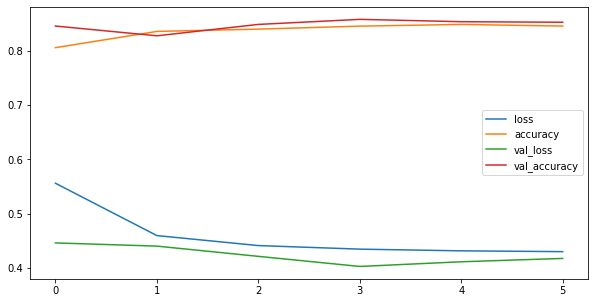

In [46]:
# plotting result
plt.figure(figsize=(10,5))
history=pd.DataFrame(history.history)
plt.plot(history)
plt.legend(history.columns)

## Evaluation

In [47]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
def measure(pred,value):
  eva_dict={'accuracy':accuracy_score(value,pred),'precision':precision_score(value,pred,average='weighted'),'recall':recall_score(value,pred,average='weighted'),'f1_score':f1_score(value,pred,average='weighted')}
  print(eva_dict)

In [48]:
Model2.evaluate(val_dataset)

945/945 [==============================] - 304s 321ms/step - loss: 0.3994 - accuracy: 0.8547


[0.3994399607181549, 0.8546603918075562]

In [49]:
pred=Model2.predict(test_df['text'])

In [50]:
pred=tf.argmax(pred,axis=1)

In [51]:
measure(pred,test_df['target'])

{'accuracy': 0.8470881035340966, 'precision': 0.8481992970820172, 'recall': 0.8470881035340966, 'f1_score': 0.8445254228601268}
